# Run cross validation on Training set

In [1]:

from sklearn.metrics import accuracy_score
import json
import numpy as np
from pathlib import Path
from my_utils import GDPRDataset, score_subtrees
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Config

In [2]:
config_file = open(f"{str(Path.cwd())}/svm_poc_cross_validation_config.json")
config = json.load(config_file)
config_file.close()

## Load Training Data into random splits

In [3]:
train_df = GDPRDataset.GDPRDataset(dataset_dir=config['train_dataset_path']).dataframe

In [4]:
# shuffle
train_df = train_df.sample(random_state=420, n=250)

In [5]:
splits = np.array_split(train_df, 5)

## Cross Validate

In [6]:
def make_svm_trainset(df):
    GDPR_texts_df = pd.DataFrame(data = {'content_removed':df[df['contains_GDPR'] == True]['content_removed']})

    GDPR_texts_df['text_word_count'] = GDPR_texts_df['content_removed'].apply(lambda x: len(str(x).split(" ")))
    GDPR_texts_df = GDPR_texts_df.reset_index()

    # Get none GDPR texts
    no_GDPR_texts_df = pd.DataFrame(data={
        'content': df[df['contains_GDPR'] == False]['content'],
    })
    no_GDPR_texts_df = no_GDPR_texts_df.reset_index()

    # trim the none GDPR texts to have similar lengths as the GDPR texts
    no_GDPR_texts = []
    for i in range(min(len(GDPR_texts_df),len(no_GDPR_texts_df))):
        text_len = GDPR_texts_df.loc[i]['text_word_count']
        no_GDPR_text = no_GDPR_texts_df.loc[i]['content']
        stripped_no_GDPR_text = " ".join(list(no_GDPR_text.split(" "))[:text_len])
        no_GDPR_texts.append(stripped_no_GDPR_text)

    no_GDPR_texts_df = pd.DataFrame(data={'stripped_text':no_GDPR_texts})

    tfifd_svm_dataset = list(GDPR_texts_df['content_removed'].values) + list(no_GDPR_texts_df['stripped_text'].values)

    labels = [1] * len(GDPR_texts_df) + [0] * len(no_GDPR_texts_df)

    tfifd_svm_dataset_df = pd.DataFrame(data={
        'text': tfifd_svm_dataset,
        'is_GDPR': labels}
    )

    return tfifd_svm_dataset_df

In [8]:
accuracies = []

scoring_model = None

for i in range(5):
    print("Test split:",i)
    test_df = splits[i]
    indizes = list(range(5))
    indizes.remove(i)
    train_splits = [splits[index] for index in indizes]

    contact_train_df = pd.concat(train_splits)

    tfidf_svm_train = make_svm_trainset(contact_train_df)

    scoring_model = score_subtrees.TFIDF_SVM_subtree_scorer(
        documents=list(contact_train_df['content'].values),
        train_dataset_df=tfidf_svm_train,
        do_text_preprocessing=True,
        pretrained_paths={
            "svm_model_path": config['best_svm_model_path'],
            "vectorizer_path": config['vectorizer_path'],
            "robust_scaler_path": config['robust_scaler_path']
        }
    )

    test_df['max_subtree_score'] = test_df['page_source_html'].apply(
        lambda html: max(list(scoring_model.get_scored_html_nodes(html)['GDPR_score'].values)))
    # parse scores + threshold to prediction
    test_df['prediction'] = test_df['max_subtree_score'].apply(lambda score: score >= 0.8)

    # get metrics
    Y = list(test_df['contains_GDPR'].values)
    Y = list(map(int, Y))

    Y_pred = list(test_df['prediction'].values)
    Y_pred = list(map(int, Y_pred))

    accuracy = accuracy_score(Y, Y_pred)

    accuracies.append(accuracy)
    print("Acc of:",accuracy)




Test split: 0
Acc of: 0.74
Test split: 1
Acc of: 0.76
Test split: 2
Acc of: 0.82
Test split: 3
Acc of: 0.78
Test split: 4


KeyboardInterrupt: 

## Determine Best threshold
SVM gives probability between 0 and 1 that the highest scoring subtree of a website is DSGVO content or not.
We need to those one threshold value. Websites where score of the best subtree is above this threshold will get classified as DSGVO websites.

In [7]:
results = dict()

for threshold in [0.5,0.7,0.8, 0.85, 0.9, 0.95]:

    print(threshold)

    accuracies = []

    for i in range(5):
        print("Test split:",i)
        test_df = splits[i]
        indizes = list(range(5))
        indizes.remove(i)
        train_splits = [splits[index] for index in indizes]

        contact_train_df = pd.concat(train_splits)

        tfidf_svm_train = make_svm_trainset(contact_train_df)

        scoring_model = score_subtrees.TFIDF_SVM_subtree_scorer(
            documents=list(contact_train_df['content'].values),
            train_dataset_df=tfidf_svm_train,
            do_text_preprocessing=True,
            pretrained_paths={
                "svm_model_path": config['best_svm_model_path'],
                "vectorizer_path": config['vectorizer_path'],
                "robust_scaler_path": config['robust_scaler_path']
            }
        )

        test_df['max_subtree_score'] = test_df['page_source_html'].apply(
            lambda html: max(list(scoring_model.get_scored_html_nodes(html)['GDPR_score'].values)))
        # parse scores + threshold to prediction
        test_df['prediction'] = test_df['max_subtree_score'].apply(lambda score: score >= threshold)

        # get metrics
        Y = list(test_df['contains_GDPR'].values)
        Y = list(map(int, Y))

        Y_pred = list(test_df['prediction'].values)
        Y_pred = list(map(int, Y_pred))

        accuracy = accuracy_score(Y, Y_pred)

        accuracies.append(accuracy)

    results[str(threshold)] = accuracies
    results[f"{threshold}_mean_Acc"] = np.mean(accuracies)

0.5
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4
0.7
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4
0.8
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4
0.85
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4
0.9
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4
0.95
Test split: 0
Test split: 1
Test split: 2
Test split: 3
Test split: 4


In [10]:
results = dict()

scoring_model = score_subtrees.TFIDF_SVM_subtree_scorer(
    documents=None,
    train_dataset_df=None,
    do_text_preprocessing=True,
    pretrained_paths={
        "svm_model_path": config['best_svm_model_path'],
        "vectorizer_path": config['vectorizer_path'],
        "robust_scaler_path": config['robust_scaler_path']
    }
)

for threshold in [0.5,0.7,0.8, 0.85, 0.9, 0.95]:
    df_for_threshold = pd.DataFrame(data=train_df)

    print(threshold)

    df_for_threshold['max_subtree_score'] = df_for_threshold['page_source_html'].apply(
        lambda html: max(list(scoring_model.get_scored_html_nodes(html)['GDPR_score'].values)))
    # parse scores + threshold to prediction
    df_for_threshold['prediction'] = df_for_threshold['max_subtree_score'].apply(lambda score: score >= threshold)

    # get metrics
    Y = list(df_for_threshold['contains_GDPR'].values)
    Y = list(map(int, Y))

    Y_pred = list(df_for_threshold['prediction'].values)
    Y_pred = list(map(int, Y_pred))

    accuracy = accuracy_score(Y, Y_pred)
    print(accuracy)
    
    results[f"{threshold}_mean_Acc"] = accuracy

0.5
0.764
0.7
0.812
0.8
0.808
0.85
0.82
0.9
0.824
0.95
0.824


In [8]:
results

{'0.5': [0.74, 0.66, 0.8, 0.7, 0.8],
 '0.5_mean_Acc': 0.74,
 '0.7': [0.76, 0.7, 0.82, 0.78, 0.84],
 '0.7_mean_Acc': 0.7799999999999999,
 '0.8': [0.78, 0.74, 0.78, 0.76, 0.86],
 '0.8_mean_Acc': 0.7839999999999999,
 '0.85': [0.8, 0.74, 0.82, 0.78, 0.86],
 '0.85_mean_Acc': 0.7999999999999999,
 '0.9': [0.78, 0.78, 0.88, 0.78, 0.82],
 '0.9_mean_Acc': 0.808,
 '0.95': [0.72, 0.82, 0.88, 0.78, 0.88],
 '0.95_mean_Acc': 0.8160000000000001}

In [0]:
plt.bar(
    x = [0.5, 0.7, 0.8, 0.85, 0.9, 0.95],
    height=[
        0.9399999999999998,
        0.9559999999999998,
        0.9559999999999998,
        0.96,
        0.9559999999999998,
        0.952
    ]
)

<AxesSubplot: >

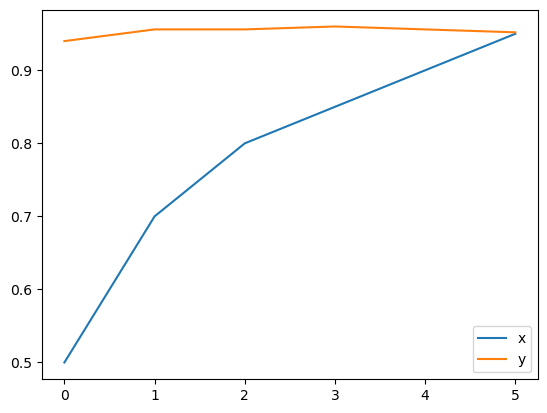

In [33]:
pd.DataFrame(data={
    'x':[0.5, 0.7, 0.8, 0.85, 0.9, 0.95],
    'y':[
        0.9399999999999998,
        0.9559999999999998,
        0.9559999999999998,
        0.96,
        0.9559999999999998,
        0.952
    ]
}).plot()